In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from anzu.emu_funcs import LPTEmulator
from anzu.utils import _cleft_pk

from velocileptors.LPT.cleft_fftw import CLEFT
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT
from scipy.interpolate import interp1d
import sys
sys.path.insert(0, '../')

#import pyccl as ccl

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'

plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18

colors = ['#8d598f', '#cd9b00', '#de2d26', '#004d00', '#3182bd'][::-1]

The `LPTEmulator` object is the class that does all of our work. The emulator is trained on the default simulation data with fiducial parameters from 2101.11014 upon instantiation. 

It is possible to tweak some settings with kwargs provided to the `LPTEmulator` object, but this is generally not recommended unless you have very good reason to.


# Anzu's original settings

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [412]:
!pwd

/Users/jderose/projects/anzu/notebooks


In [144]:
st = time.time()

emu = LPTEmulator(aemulus_alpha_settings=True, 
                  nbody_training_data_file='/Users/jderose/projects/anzu/anzu/data/spectra_aem_compensated.npy',
                  lpt_training_data_file='/Users/jderose/projects/anzu/anzu/data/cleft_spectra_twores.npy',
                  kbin_file='/Users/jderose/projects/anzu/anzu/data/kbins.npy'
                 )

 /Users/jderose/projects/anzu/anzu/emu_funcs.py:333: RuntimeWarning:invalid value encountered in log10


IndexError: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 43

> /Users/jderose/projects/anzu/anzu/emu_funcs.py(340)_ratio_and_smooth()
    338         self.nk = self.kmax_idx - self.kmin_idx
    339 
--> 340         simoverlpt = simoverlpt[self.training_idx, self.zidx :, :, self.kmin_idx : self.kmax_idx]
    341 
    342         return simoverlpt

ipdb> q


Now we're ready to make predictions. The default emulator makes predictions as a function of \\(\Omega_b h^2,\, \Omega_c h^2,\, w,\, n_s,\, \sigma_8,\, H_0,\, N_{\rm eff},\, a\\) in that order. You will also need to provide an array of wavenumbers that you want to compute spectra at, which should be in units of \\(h^{-1}\rm Mpc\\).

In [4]:
def compute_velocileptors_spectra(cosmovec, snapscale, use_physical_densities=True, 
                                  use_sigma_8=True, kecleft=True, cleftobj=None):
    '''
    Returns a spline object which computes the cleft component spectra. Computed either in
    "full" CLEFT or in "k-expanded" CLEFT which allows for faster redshift dependence.
    Args:
        cosmovec : array-like
            Vector containing cosmology in the order (ombh2, omch2, w0, ns, sigma8, H0, Neff).
            If self.use_sigma_8 != True, then ln(A_s/10^{-10}) should be provided instead of sigma8.
        snapscale : float
            scale factor
        kecleft: bool
            Bool to check if the calculation is being made with 
    Returns:
        cleft_aem : InterpolatedUnivariateSpline 
            Spline that computes basis spectra as a function of k
    '''

    if use_physical_densities:
        if use_sigma_8:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0] / (cosmovec[5] / 100)**2,
                                  Omega_c=cosmovec[1] /
                                  (cosmovec[5] / 100)**2,
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  sigma8=cosmovec[4])
        else:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0] / (cosmovec[5] / 100)**2,
                                  Omega_c=cosmovec[1] /
                                  (cosmovec[5] / 100)**2,
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  A_s=np.exp(cosmovec[4]) * 1e-10)
    else:
        if use_sigma_8:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0],
                                  Omega_c=cosmovec[1] - cosmovec[0],
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  sigma8=cosmovec[4])
        else:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0],
                                  Omega_c=cosmovec[1] - cosmovec[0],
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  A_s=np.exp(cosmovec[4]) * 1e-10)

    k = np.logspace(-3, 1, 1000)

    if kecleft:
        # If using kecleft, check that we're only varying the redshift

        if cleftobj is None:
            # Do the full calculation again, as the cosmology changed.
            pk = ccl.linear_matter_power(
                cosmo, k * cosmo['h'], 1) * (cosmo['h'])**3

            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, pk)

        # Adjust growth factors
        D = ccl.background.growth_factor(cosmo, snapscale)
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        pk = ccl.linear_matter_power(
            cosmo, k * cosmo['h'], snapscale) * (cosmo['h'])**3
        cleftobj = CLEFT(k, pk, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, pk, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    cleftpk[3:, :] = cleftobj.pktable.T[3:, :]
    cleftpk[2, :] /= 2
    cleftpk[6, :] /= 0.25
    cleftpk[7, :] /= 2
    cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')

    return cleftspline, cleftobj

In [48]:

cosmo_vec = np.atleast_2d([0.023, 0.108, -0.73, 0.98, 0.69,  63.2,  2.95,  1.0])

#compute p_lin to feed to velocileptors
snapscale = cosmo_vec[0,-1]
cosmovec = cosmo_vec[0,:]

lpt_interp, cleftobk = compute_velocileptors_spectra(cosmovec, snapscale,
                                                     use_physical_densities=emu.use_physical_densities,
                                                     use_sigma_8=emu.use_sigma_8, kecleft=False)
lpt_spec = lpt_interp(emu.k)[1:11,:]

k_emu = np.logspace(-2, 0, 100)
emu_spec = emu.predict(k_emu, cosmo_vec, spec_lpt=lpt_spec)

We can also read in the Aemulus test cosmologies and measure the emulators accuracy on a set of simulations that it is not trained on. 

In [49]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

# this is a helper function to set up an array to make predictions for all redshifts that there 
# are Aemulus snapshots for all Aemulus test cosmologies. It's not necessary to use this for 
# arbitrary cosmologies/redshifts. 

In [50]:
lpt_spec = np.zeros((len(design_test),10,700))

for i, c in enumerate(design_test):
    lpt_interp, cleftobk = compute_velocileptors_spectra(c, c[-1],
                                                         use_physical_densities=emu.use_physical_densities,
                                                         use_sigma_8=emu.use_sigma_8, kecleft=False)    
    lpt_spec[i,...] = lpt_interp(emu.k)[1:11,:]


ValueError: Trying to compute spectra beyond the maximum value of the emulator!

In [51]:
pce_spec = emu.predict(k_emu, np.atleast_2d(design_test), spec_lpt=lpt_spec)

Now we can plot the predictions, here just for \\( z=0\\) for the 7 test cosmologies.

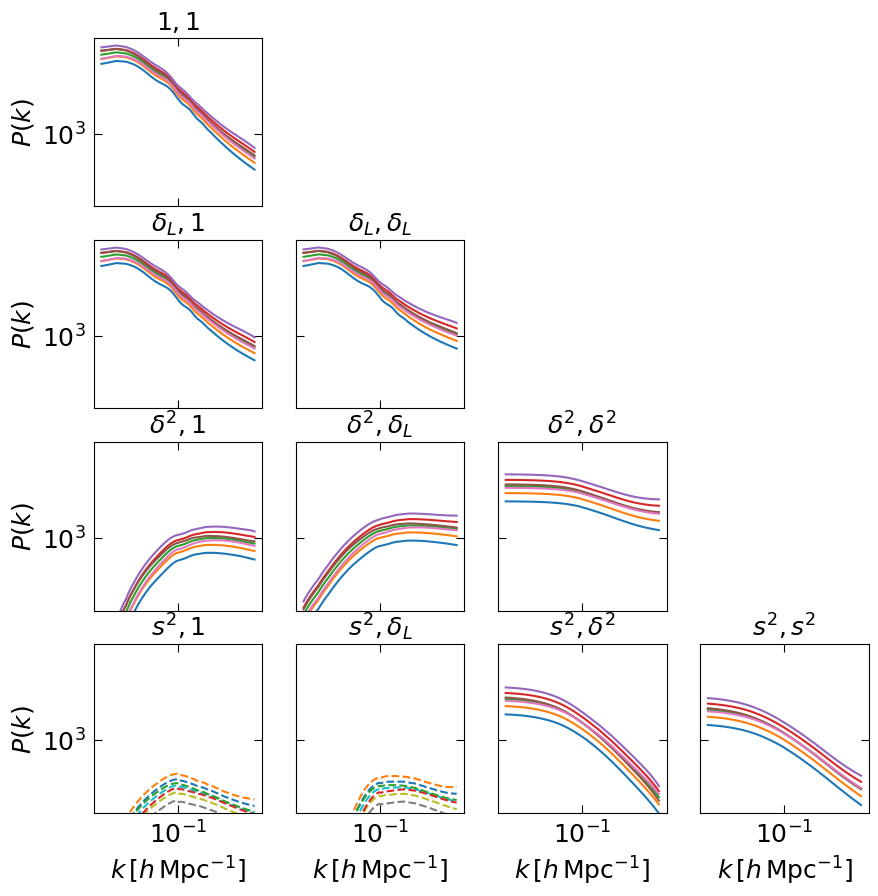

In [53]:
f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
components = ['1', '\delta_L', '\delta^2', 's^2']

pce_spec_reshape = pce_spec.reshape(7, 9, 10, -1)

#plot z=0 predictions
z_idx = -1 

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].loglog(k_emu, pce_spec_reshape[:,z_idx,counter,:].T)
        l0 = ax[i,j].loglog(k_emu, -pce_spec_reshape[:,z_idx,counter,:].T, ls='--')

        counter += 1
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))

        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'$P(k)$')


f.set_figheight(10)
f.set_figwidth(10)


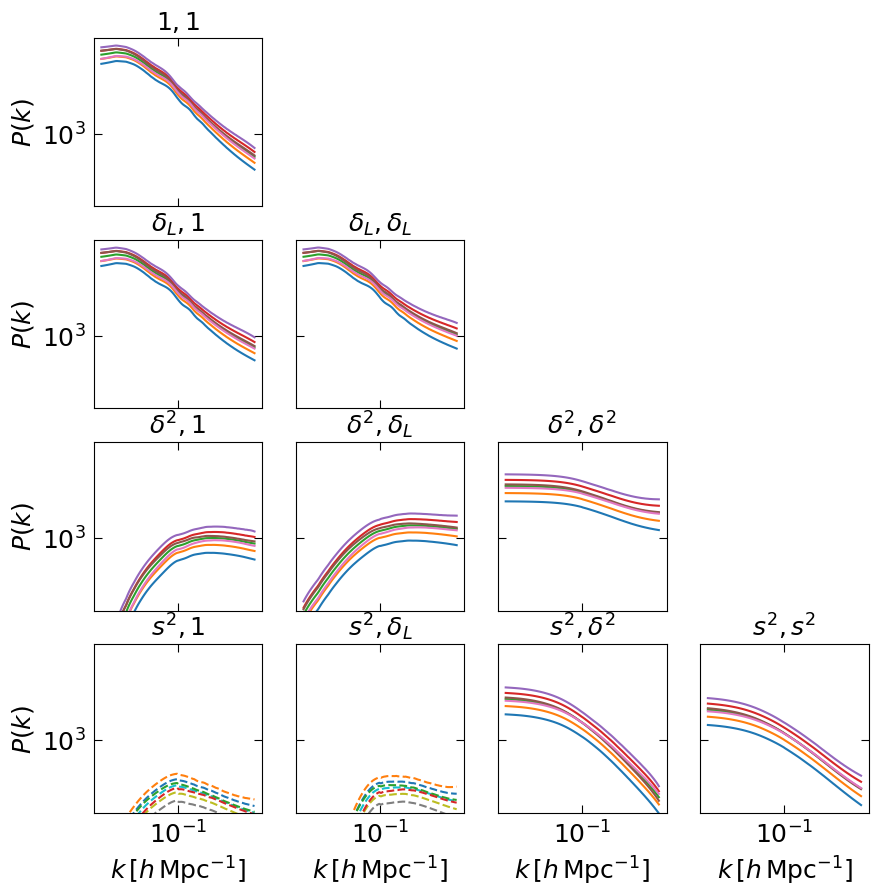

In [7]:
f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
components = ['1', '\delta_L', '\delta^2', 's^2']

pce_spec_reshape = pce_spec.reshape(7, 9, 10, -1)

#plot z=0 predictions
z_idx = -1 

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].loglog(k, pce_spec_reshape[:,z_idx,counter,:].T)
        l0 = ax[i,j].loglog(k, -pce_spec_reshape[:,z_idx,counter,:].T, ls='--')

        counter += 1
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))

        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'$P(k)$')


f.set_figheight(10)
f.set_figwidth(10)


For something a little more complicated, we can also test the accuracy of the emulator against the measured spectra from the Aemulus test boxes. Here we remake one of the accuracy figures from the original paper.

In [415]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load('{}/cleft_spectra_test.npy'.format(dirname))
spectra_aem_test = np.load('{}/spectra_aem_test_compensated_fixedgrowth.npy'.format(dirname))
spectra_aem_test_mean = np.nanmean(spectra_aem_test, axis=1)

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(spectra_lpt_test)
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx

spectra_aem_reshape = spectra_aem_test_mean[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_lpt_test_reshape = spectra_lpt_test[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_aem_test_mean = spectra_aem_test_mean[:,zidx:,...]


In [416]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, spec_lpt=spectra_lpt_test_reshape)
pce_spec = pce_spec.reshape(7, emu.nz, 10, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, spec_lpt=spectra_lpt_test_reshape,
                                   evec_spec=emu.evec_spec[...,:2], simoverlpt=simoverlpt_test)
pca_spec = pca_spec.reshape(7, emu.nz, 10, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])

counter = 0
dk = k[1:] - k[:-1]

for i in range(4):
    for j in range(4):
        if j>i:
            continue

        for ki in range(nz):
            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]

        counter+=1

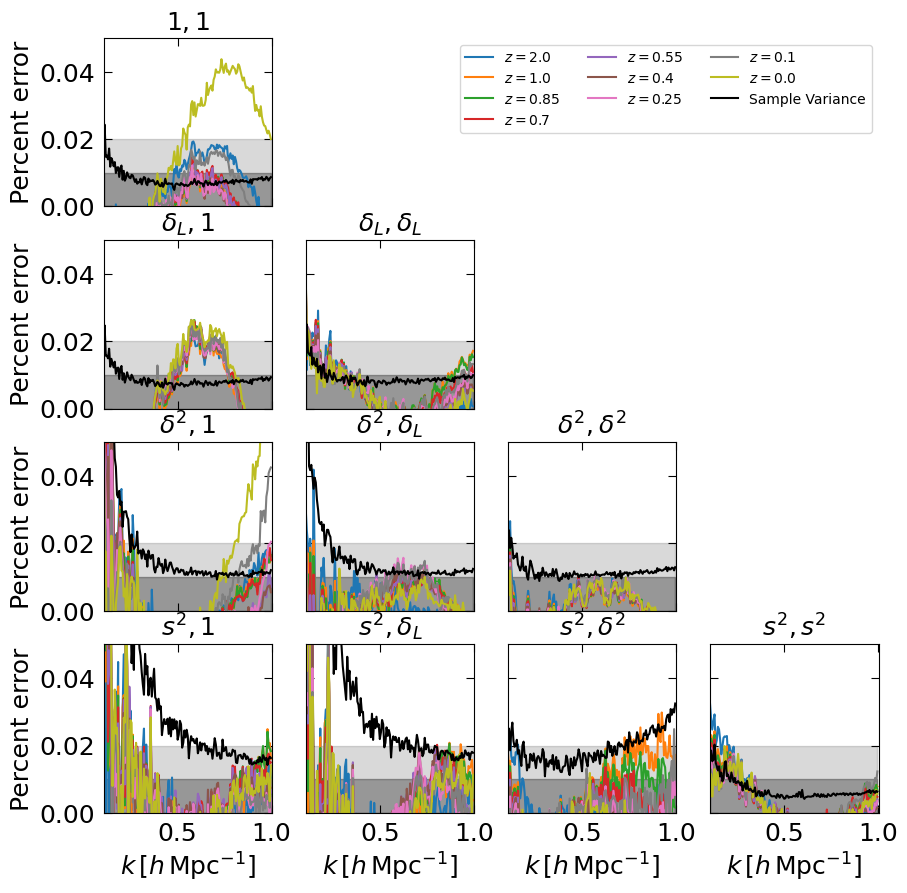

In [418]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(resids_emu[:,:,counter,kmin_idx:kmax_idx].T, 50, axis=-1))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


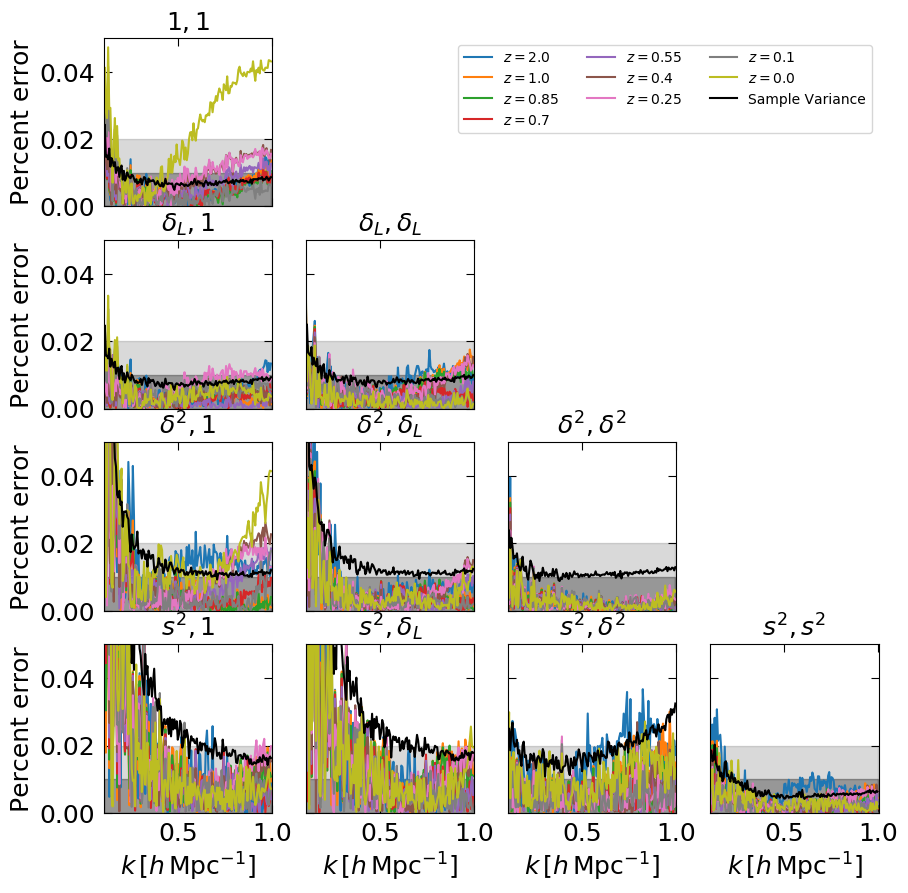

In [10]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.abs(resids_emu[tbcount,:,counter,kmin_idx:kmax_idx].T))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


In [11]:
print('Running through all of CLEFT took ',  time.time() - st)

Running through all of CLEFT took  221.2163712978363


# Anzu with 'k-Expanded CLEFT' (KECLEFT)

Below we present the same residual plots as above but with a new experimental setting in Anzu. Instead of using the fully resummed CLEFT predictions from `velocileptors` we use a new module that performs `k-expanded CLEFT` (KECLEFT), detailed in Appendix E of https://arxiv.org/pdf/2005.00523.pdf . Calculations in KECLEFT are significantly faster than standard CLEFT, especially when varying redshift and keeping cosmology the same. 

The cells below show the performance of a KECLEFT-based emulator. Note that we don't change the settings compared to what was originally settled on in our paper, so there could be room for improvement. 

Switching to KECLEFT mode is as simple as initializing an `LPTEmulator` with `kecleft=True`. 
**Caveat emptor: this version is still experimental and not incredibly verified. Use it at your own risk or get in touch with one of the Anzu developers if you have questions.**

In [60]:
st = time.time()

emu = LPTEmulator(kecleft=True, aemulus_alpha_settings=True)

 /Users/jderose/projects/anzu/anzu/emu_funcs.py:183: UserWarning:kecleft and extrap are both set. Setting extrap to False.


Now we're ready to make predictions. The default emulator makes predictions as a function of \\(\Omega_b h^2,\, \Omega_c h^2,\, w,\, n_s,\, \sigma_8,\, H_0,\, N_{\rm eff},\, a\\) in that order. You will also need to provide an array of wavenumbers that you want to compute spectra at, which should be in units of \\(h^{-1}\rm Mpc\\).

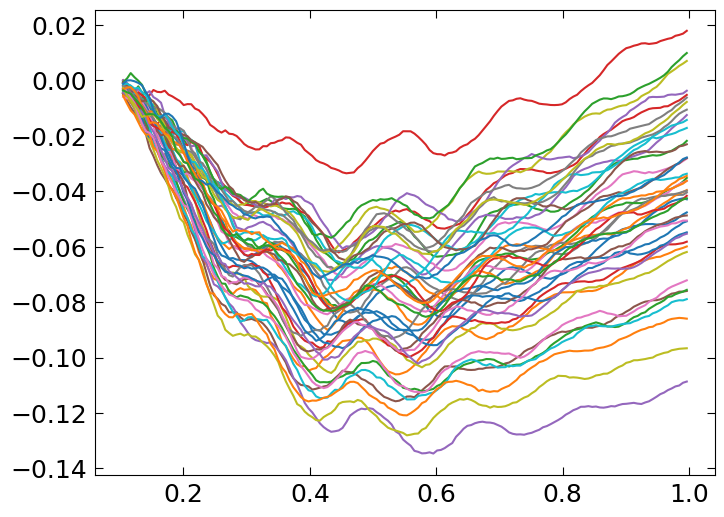

In [153]:
plt.plot(emu.k[emu.kmin_idx:emu.kmax_idx], emu.simoverlpt[:,-3,0,:].T);

In [147]:
cosmo_vec = np.atleast_2d([0.023, 0.108, -0.73, 0.98, 0.69,  63.2,  2.95,  1.0])

#compute p_lin to feed to velocileptors
snapscale = cosmo_vec[0,-1]
cosmovec = cosmo_vec[0,:]
k_emu = np.logspace(-2, 0, 100)

lpt_interp, cleftobk = compute_velocileptors_spectra(cosmovec, snapscale,
                                                     use_physical_densities=emu.use_physical_densities,
                                                     use_sigma_8=emu.use_sigma_8, kecleft=True)
lpt_spec = lpt_interp(k_emu)[1:11,:]

emu_spec = emu.predict(k_emu, cosmo_vec, spec_lpt=lpt_spec)

NameError: name 'compute_velocileptors_spectra' is not defined

> /var/folders/q3/6gs6_y8s2g18tsm2881649l80000gn/T/ipykernel_14117/3948518312.py(8)<module>()
      6 k_emu = np.logspace(-2, 0, 100)
      7 
----> 8 lpt_interp, cleftobk = compute_velocileptors_spectra(cosmovec, snapscale,
      9                                                      use_physical_densities=emu.use_physical_densities,
     10                                                      use_sigma_8=emu.use_sigma_8, kecleft=True)

ipdb> q


We can also read in the Aemulus test cosmologies and measure the emulators accuracy on a set of simulations that it is not trained on. 

In [13]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

# this is a helper function to set up an array to make predictions for all redshifts that there 
# are Aemulus snapshots for all Aemulus test cosmologies. It's not necessary to use this for 
# arbitrary cosmologies/redshifts.

lpt_spec = np.zeros((len(design_test),10,100))
last_c = None
cleftobj = None

for i, c in enumerate(design_test):
    
    if last_c is not None:
        if (last_c[:-1] == c[:-1]).all():
            lpt_interp, cleftobj = compute_velocileptors_spectra(c, c[-1],
                                                                 use_physical_densities=emu.use_physical_densities,
                                                                 use_sigma_8=emu.use_sigma_8, kecleft=True, 
                                                                 cleftobj=cleftobj)
        else:
            lpt_interp, cleftobj = compute_velocileptors_spectra(c, c[-1],
                                                                 use_physical_densities=emu.use_physical_densities,
                                                                 use_sigma_8=emu.use_sigma_8, kecleft=True, 
                                                                 cleftobj=None)                                                             

    lpt_spec[i,...] = lpt_interp(k_emu)[1:11,:]
    
    last_c = c


In [15]:
pce_spec = emu.predict(k_emu, np.atleast_2d(design_test), spec_lpt=lpt_spec)

Now we can plot the predictions, here just for \\( z=0\\) for the 7 test cosmologies.

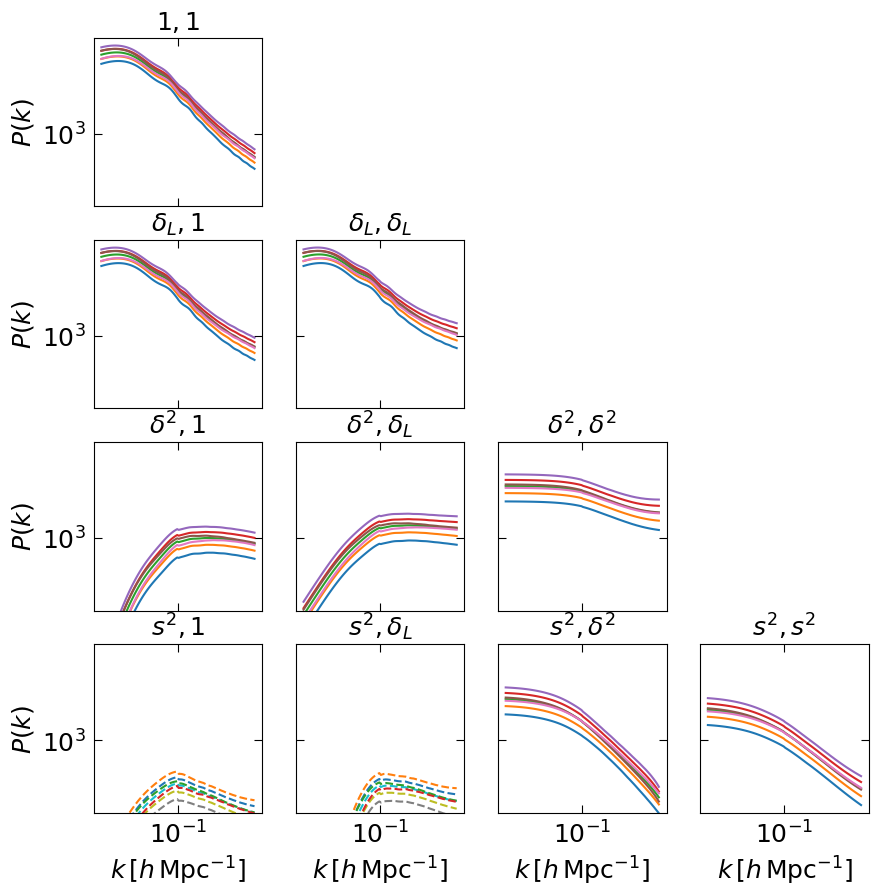

In [16]:
f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
components = ['1', '\delta_L', '\delta^2', 's^2']

pce_spec_reshape = pce_spec.reshape(7, 9, 10, -1)

#plot z=0 predictions
z_idx = -1 

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].loglog(k_emu, pce_spec_reshape[:,z_idx,counter,:].T)
        l0 = ax[i,j].loglog(k_emu, -pce_spec_reshape[:,z_idx,counter,:].T, ls='--')

        counter += 1
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))

        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'$P(k)$')


f.set_figheight(10)
f.set_figwidth(10)


For something a little more complicated, we can also test the accuracy of the emulator against the measured spectra from the Aemulus test boxes. Here we remake one of the accuracy figures from the original paper.

In [61]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load('{}/kecleft_spectra_test.npy'.format(dirname))
spectra_aem_test = np.load('{}/spectra_aem_test_compensated_fixedgrowth.npy'.format(dirname))
spectra_aem_test_mean = np.nanmean(spectra_aem_test, axis=1)

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(np.copy(spectra_lpt_test))
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx

spectra_aem_reshape = spectra_aem_test_mean[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_lpt_test_reshape = spectra_lpt_test[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_aem_test_mean = spectra_aem_test_mean[:,zidx:,...]
spectra_aem_alpha_test = np.copy(spectra_aem_test)

In [62]:
spectra_aem_test = np.load('{}/spectra_aem_test_compensated_fixedgrowth.npy'.format(dirname))
spectra_aem_alpha_test = np.copy(spectra_aem_test)

In [150]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, spec_lpt=spectra_lpt_test_reshape[...,:emu.kmax_idx])
pce_spec = pce_spec.reshape(7, emu.nz, 10, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, 
                       evec_spec=emu.evec_spec[...,:2], simoverlpt=simoverlpt_test,
                       spec_lpt=spectra_lpt_test_reshape[...,:emu.kmax_idx])
pca_spec = pca_spec.reshape(7, emu.nz, 10, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])

counter = 0
dk = k[1:] - k[:-1]

for i in range(4):
    for j in range(4):
        if j>i:
            continue

        for ki in range(nz):
            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]

        counter+=1

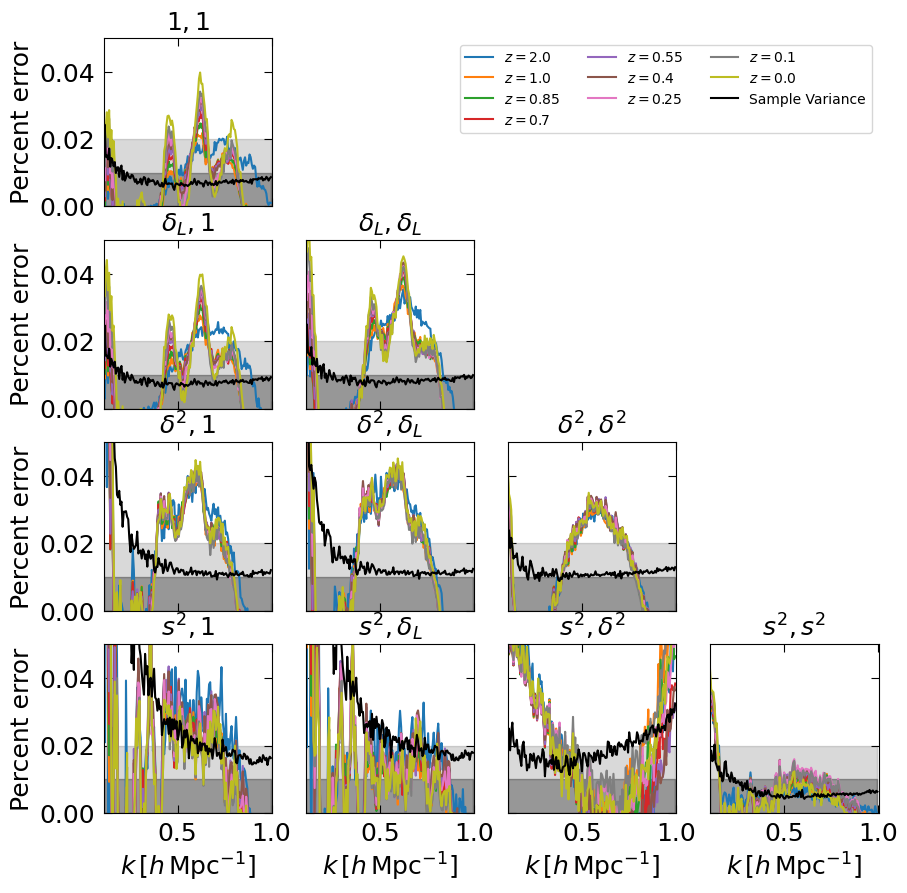

In [152]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(resids_emu[:,:,counter,kmin_idx:kmax_idx].T, 66, axis=-1))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


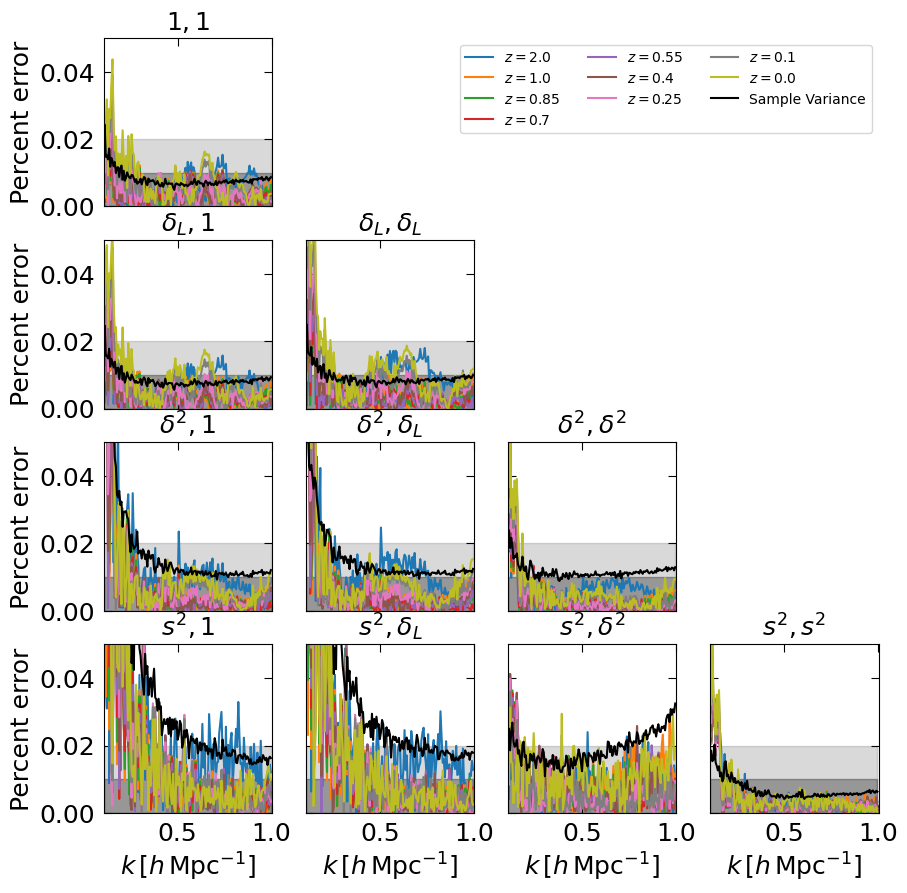

In [23]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.abs(resids_emu[tbcount,:,counter,kmin_idx:kmax_idx].T))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


In [20]:
print('Running through all of KECLEFT took ', time.time() - st)

Running through all of KECLEFT took  25.4784677028656


In [4]:
%pdb

Automatic pdb calling has been turned ON


In [6]:
scalefacs = np.logspace(np.log10(0.25), np.log10(1), 30)
zs = 1/scalefacs -1

In [226]:
st = time.time()
train_nbody_file = '../anzu/data/zcv_za_aemulus_nu_combtier_spectra.npy'
train_lpt_file =   '../anzu/data/kelpt_aemulus_nu_combtier_spectra.npy'
train_cosmo_file = '../anzu/data/aemulus_nu_combtier_cosmos.txt'
k_file = '../anzu/data/kbins_aemulus_nu.npy'
z_file = '../anzu/data/'
npc=5
#
emu_pce = LPTEmulator(aemulus_alpha_settings=False, nbody_training_data_file=train_nbody_file,
                  lpt_training_data_file=train_lpt_file, training_cosmo_file=train_cosmo_file,
                  zs=zs, kbin_file=k_file, extrap=True, use_sigma_8=True, 
                  smooth_spectra=True, tanh=False, kmax=1, kmin=0.1,
                  hyperparams={'npc':npc, 'ncv':None, 'degree_cv':0, 
                               'npoly':np.array([1, 2, 2, 2, 3, 2, 2, 3])},
#                  surrogate_type='GP',
                  kmin_pl=1.0, kmax_pl=1.2, param_bound_dict={'sigma8':[0.7,0.9]}
                  
)

 /Users/jderose/projects/anzu/anzu/emu_funcs.py:333: RuntimeWarning:invalid value encountered in log10


In [227]:
np.sum(emu_pce.training_idx)

80

In [224]:
train_nbody_file

'../anzu/data/zcv_za_aemulus_nu_combtier_spectra.npy'

In [201]:
npc=5
emu = LPTEmulator(aemulus_alpha_settings=False, nbody_training_data_file=train_nbody_file,
                  lpt_training_data_file=train_lpt_file, training_cosmo_file=train_cosmo_file,
                  zs=zs, kbin_file=k_file, param_bound_dict={'sigma8':[0.7,0.9]}, 
                  hyperparams={'npc':npc, 'ncv':None, 'degree_cv':0, 
                               'npoly':np.array([1, 2, 2, 2, 3, 2, 2, 4]),
                              },
                  surrogate_type='GP',
                               
                  kmin_pl=1.0, kmax_pl=1.2,
)

fitting spec 0
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 1
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 2
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 3
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 4
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 5
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 6
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 7
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 8
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 9
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 10
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 11
fitting pc 0
fitting pc 1
fitting pc 2
fitting pc 3
fitting pc 4
fitting spec 12
fitting pc 0
fitting p

In [202]:
nbody_file = '../anzu/data/zcv_za_aemulus_nu_tier2_spectra.npy'
lpt_file =   '../anzu/data/kelpt_aemulus_nu_tier2_spectra.npy'
cosmo_file = '../anzu/data/aemulus_nu_tier2_cosmos.txt'
nsim = 44
design_test, design_test_scaled = emu._setup_design(cosmo_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load(lpt_file)
spectra_aem_test = np.load(nbody_file)
spectra_aem_test_mean = spectra_aem_test

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(np.copy(spectra_lpt_test))
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx
test_cosmos = np.genfromtxt(cosmo_file, names=True)
idx = (0.7 < test_cosmos['sigma8']) & (test_cosmos['sigma8'] < 0.9)
nsim = np.sum(idx)
spectra_aem_reshape = spectra_aem_test_mean[idx,zidx:,...].reshape(nsim * emu.nz, emu.nspec, -1)
spectra_lpt_test_reshape = spectra_lpt_test[idx,zidx:,...].reshape(nsim * emu.nz, emu.nspec, -1)
spectra_aem_test_mean = spectra_aem_test_mean[idx,zidx:,...]



 /Users/jderose/projects/anzu/anzu/emu_funcs.py:333: RuntimeWarning:invalid value encountered in log10


In [203]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, spec_lpt=spectra_lpt_test_reshape)#[...,:emu.kmax_idx])
pce_spec = pce_spec.reshape(nsim, emu.nz, emu.nspec, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, 
                       evec_spec=emu.evec_spec[...,:npc], simoverlpt=simoverlpt_test,
                       spec_lpt=spectra_lpt_test_reshape)#[...,:emu.kmax_idx])
pca_spec = pca_spec.reshape(nsim, emu.nz, emu.nspec, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

#resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
#resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
#
#counter = 0
#dk = k[1:] - k[:-1]
#            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#
#for i in range(4):
#    for j in range(4):
#        if j>i:
#            continue
#
#        for ki in range(nz):
#            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#
#        counter+=1

In [204]:
resids_emu = (pce_spec[:,:,:,:] - spectra_aem_test_mean[:,:,:,:kmax_idx])/spectra_aem_test_mean[:,:,:,:kmax_idx]
resids_pca = (pca_spec[:,:,:,:] - spectra_aem_test_mean[:,:,:,:kmax_idx])/spectra_aem_test_mean[:,:,:,:kmax_idx]

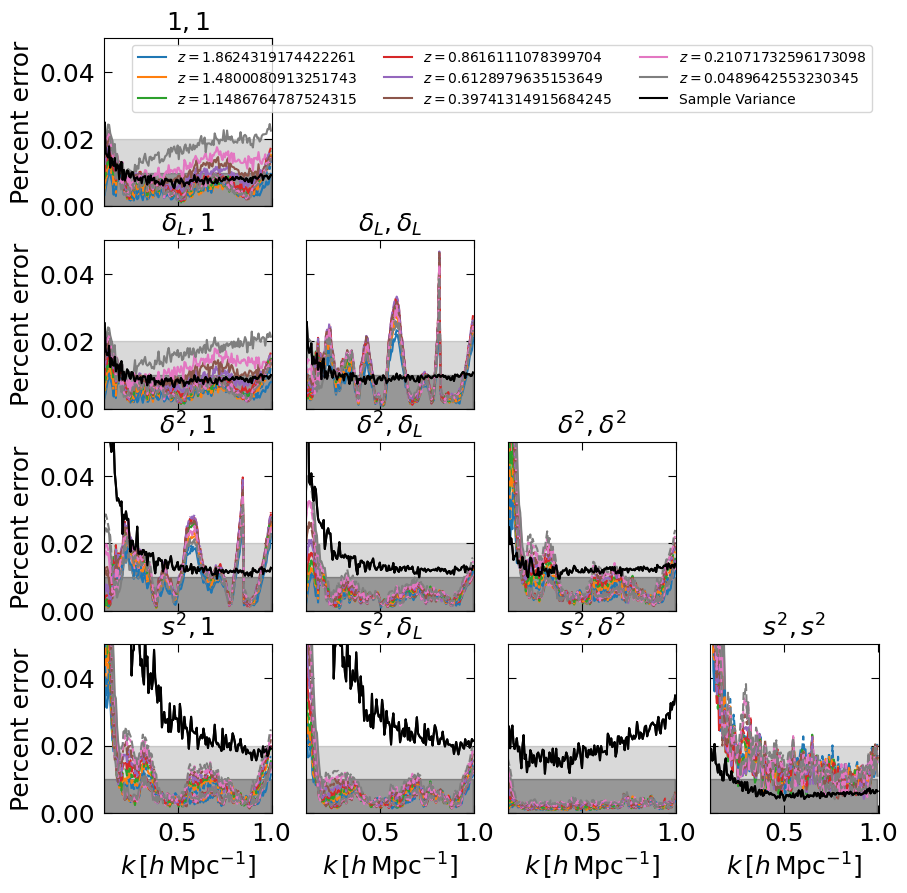

In [207]:
varpk = np.nanmean(np.nanstd(spectra_aem_alpha_test, axis=1), axis=(0))
meanpk = np.nanmean(np.nanmean(spectra_aem_alpha_test, axis=1), axis=(0))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
zstep = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(np.abs(resids_emu[:,::zstep,counter,kmin_idx:kmax_idx].T), 50, axis=-1))

        
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[-1, counter, kmin_idx:kmax_idx].T/np.abs(meanpk[-1,counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[emu.zidx::zstep]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)

#plt.gca().set_prop_cycle(None)
counter = 0
for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        ax[i,j].set_prop_cycle(None)
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(np.abs(resids_pca[:,::zstep,counter,kmin_idx:kmax_idx].T), 66, axis=-1), ls='--')
        
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[-1, counter, kmin_idx:kmax_idx].T/np.abs(meanpk[-1,counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
                    

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])

f.set_figheight(10)
f.set_figwidth(10)


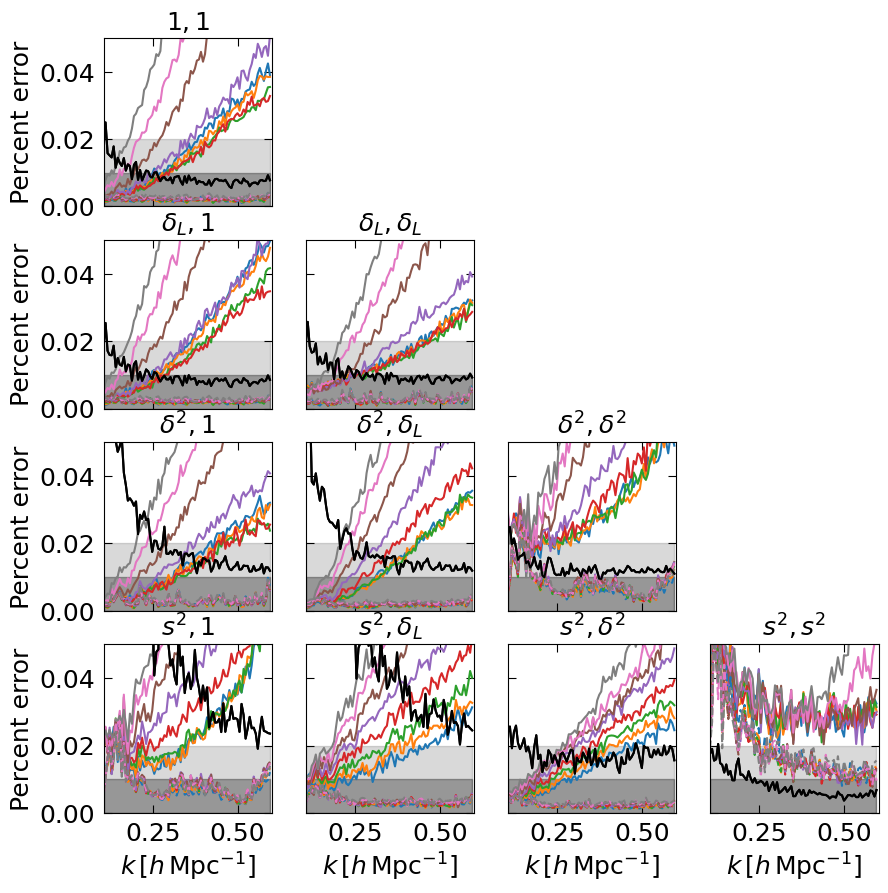

In [424]:
varpk = np.nanmean(np.nanstd(spectra_aem_alpha_test, axis=1), axis=(0))
meanpk = np.nanmean(np.nanmean(spectra_aem_alpha_test, axis=1), axis=(0))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
zstep = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(np.abs(resids_emu[:,::zstep,counter,kmin_idx:kmax_idx].T), 66, axis=-1))

        
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[-1, counter, kmin_idx:kmax_idx].T/np.abs(meanpk[-1,counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')
            
#plt.gca().set_prop_cycle(None)
counter = 0
for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        ax[i,j].set_prop_cycle(None)
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(np.abs(resids_pca[:,::zstep,counter,kmin_idx:kmax_idx].T), 66, axis=-1), ls='--')
        
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[-1, counter, kmin_idx:kmax_idx].T/np.abs(meanpk[-1,counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
                    

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
#ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


 /var/folders/q3/6gs6_y8s2g18tsm2881649l80000gn/T/ipykernel_15761/1418475580.py:6: UserWarning:Attempt to set non-positive xlim on a log-scaled axis will be ignored.


(0.0, 1.0)

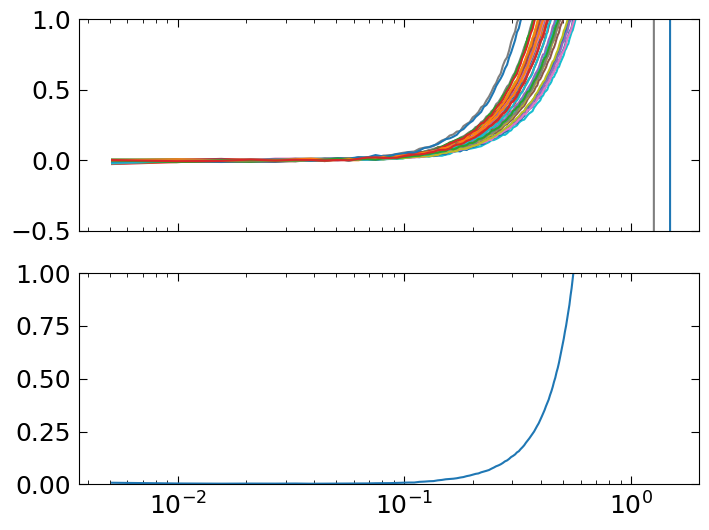

In [278]:
idx = 0
f, ax = plt.subplots(2,1,sharex=True)
ax[0].semilogx(k, spectra_aem_test[:,-1,idx,:].T/spectra_lpt_test[:,-1,idx,:].T-1);
ax[1].semilogx(k, np.nanstd(spectra_aem_test[:,-1,idx,:].T/spectra_lpt_test[:,-1,idx,:].T, axis=-1));

ax[0].set_xlim([0.0,2])
ax[0].set_ylim([-0.5,1])
ax[1].set_ylim([0, 1])

 /var/folders/q3/6gs6_y8s2g18tsm2881649l80000gn/T/ipykernel_15761/2320009558.py:6: UserWarning:Attempt to set non-positive xlim on a log-scaled axis will be ignored.


(0.0, 1.0)

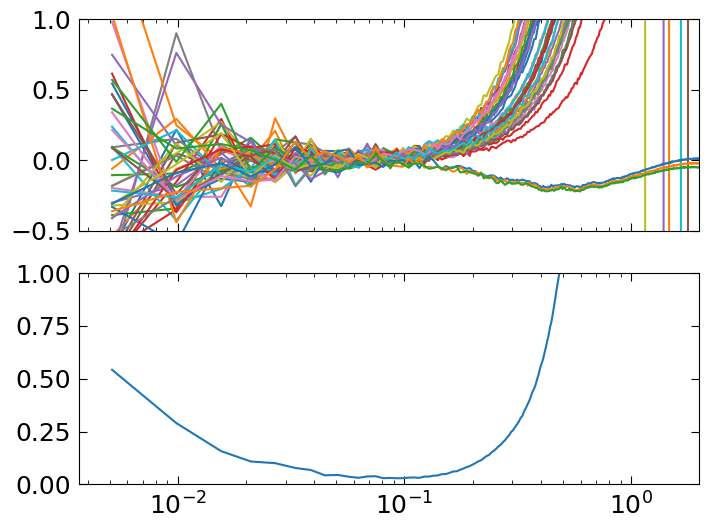

In [276]:
idx = 0
f, ax = plt.subplots(2,1,sharex=True)
ax[0].semilogx(k, emu.spectra_aem[:,-1,idx,:-1].T/emu.spectra_lpt[:,-1,idx,:-1].T-1);
ax[1].semilogx(k, np.nanstd(emu.spectra_aem[:,-1,idx,:-1].T/emu.spectra_lpt[:,-1,idx,:-1].T, axis=-1));

ax[0].set_xlim([0.0,2])
ax[0].set_ylim([-0.5,1])
ax[1].set_ylim([0, 1])

In [273]:
emu_kecleft = LPTEmulator(kecleft=True, aemulus_alpha_settings=True)


 /Users/jderose/projects/anzu/anzu/emu_funcs.py:175: UserWarning:kecleft and extrap are both set. Setting extrap to False.


 /var/folders/q3/6gs6_y8s2g18tsm2881649l80000gn/T/ipykernel_15761/3627196507.py:6: UserWarning:Attempt to set non-positive xlim on a log-scaled axis will be ignored.


(0.0, 1.0)

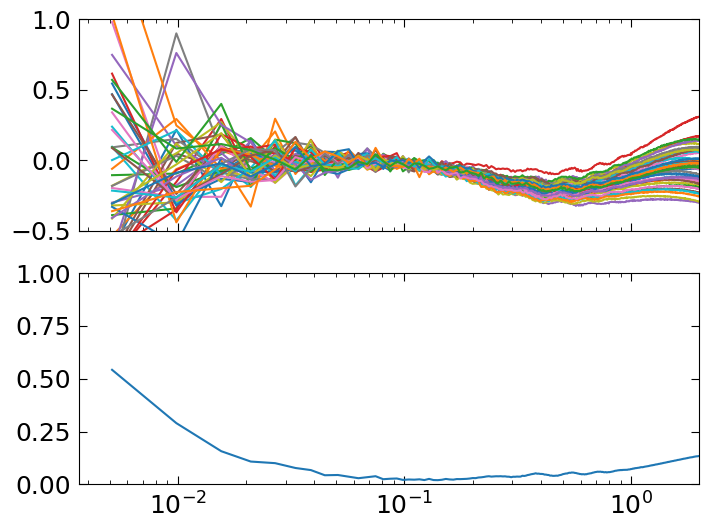

In [274]:
idx = 0
f, ax = plt.subplots(2,1,sharex=True)
ax[0].semilogx(k, emu_kecleft.spectra_aem[:,-1,idx,:-1].T/emu_kecleft.spectra_lpt[:,-1,idx,:-1].T-1);
ax[1].semilogx(k, np.nanstd(emu_kecleft.spectra_aem[:,-1,idx,:-1].T/emu_kecleft.spectra_lpt[:,-1,idx,:-1].T, axis=-1));

ax[0].set_xlim([0.0,2])
ax[0].set_ylim([-0.5,1])
ax[1].set_ylim([0, 1])

In [419]:

emu_orig = LPTEmulator(aemulus_alpha_settings=True, 
                  nbody_training_data_file='/Users/jderose/projects/anzu/anzu/data/spectra_aem_compensated.npy',
                  lpt_training_data_file='/Users/jderose/projects/anzu/anzu/data/cleft_spectra_twores.npy',
                  kbin_file='/Users/jderose/projects/anzu/anzu/data/kbins.npy'
                 )

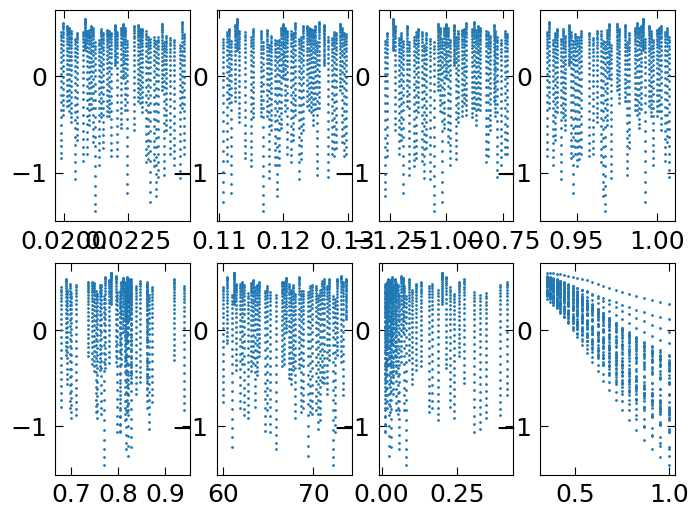

In [526]:
f, ax = plt.subplots(2,4)
pc_idx=0
for i in range(8):
#    ax[i//4,i%4].plot(emu_kecleft.design[:,i], emu_kecleft.pcs_spec_normed[:,0,pc_idx], marker='o', ls='', markersize=1)
#    ax[i//4,i%4].plot(emu_orig.design[:,i], emu_orig.pcs_spec_normed[:,0,pc_idx], marker='o', ls='', markersize=1)
    ax[i//4,i%4].plot(emu.design[:,i], emu.pcs_spec_normed[:,0,pc_idx], marker='o', ls='', markersize=1)


In [33]:
emu.spectra_aem_var.shape

(91, 30, 14, 699)

In [37]:
dk = emu.k[1] - emu.k[0]

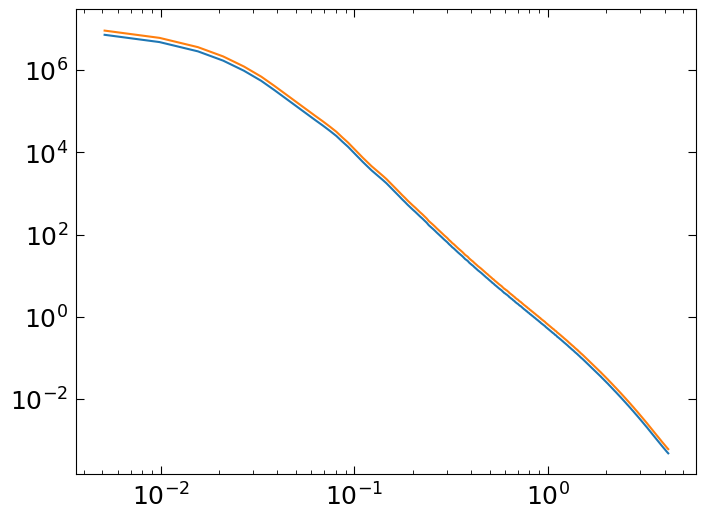

In [38]:
plt.loglog(emu.k, emu.spectra_aem_var[0,-1,0,:])
plt.loglog(emu.k, 3 * np.pi**2 * emu.spectra_aem[0,-1,0,:]**2 / (emu.k**2 * dk * 1050**3))

<ErrorbarContainer object of 3 artists>

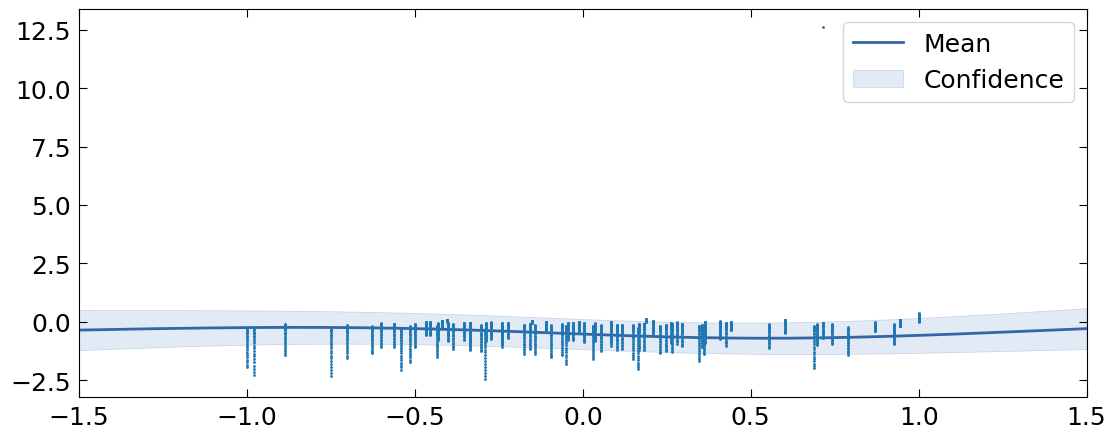

In [222]:
#f, ax = plt.subplots(1,1)
idx=5
pc_idx=0
m = emu.surrogates[0][pc_idx]
fig, ax = plt.subplots(1,1,figsize=(13,5))
m.plot_f(ax=ax, fixed_inputs=[(i,0.) for i in range(8) if i != idx])
ax.errorbar(emu.design_scaled[:,idx], emu.pcs_spec[:,0,pc_idx], np.sqrt(emu.pc_vars_spec[:,0,pc_idx]), marker='o', ls='', markersize=1)
##m.plot_errorbars_trainset(ax=ax, alpha=1)
#fig.tight_layout()

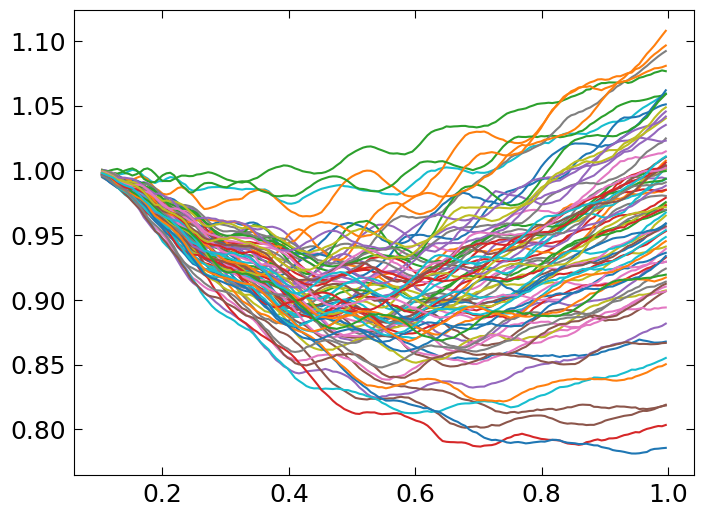

In [189]:
plt.plot(emu.k[emu.kmin_idx:emu.kmax_idx], 10**emu.simoverlpt[:,10,0,:].T);

(array([966.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 966.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 966.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 966.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        966.]),
 array([2.13820496e-06, 2.28013032e-06, 2.42205569e-06, 2.56398105e-06,
        2.70590641e-06, 2.84783177e-06, 2.98975714e-06, 3.13168250e-06,
        3.27360786e-06, 3.41553322e-06, 3.55745859e-06, 3.69938395e-06,
        3.84130931e-06, 3.98323467e-06, 4.12516004e-06, 4.26708540e-06,
        4.40901076e-06, 4.5509

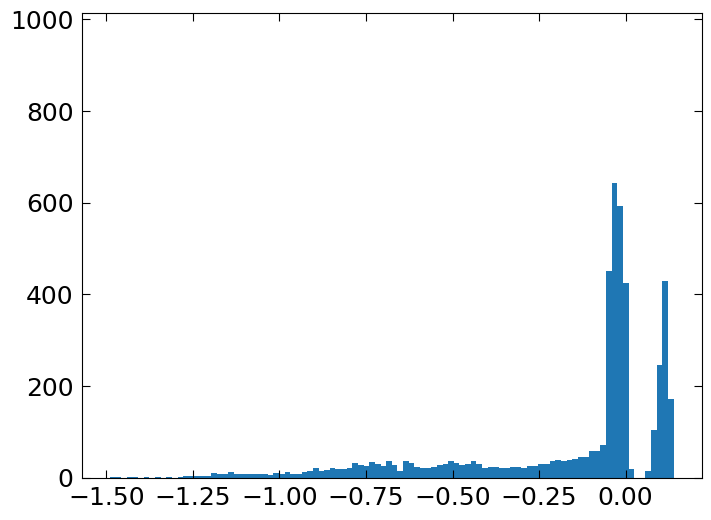

In [125]:
plt.hist(emu.pcs_spec[:,4].flatten(), 100)
plt.hist(emu.pc_vars_spec[:,4].flatten(), 100)

In [117]:
m['.*het_Gauss.variance']

gp.het_Gauss.variance:
Param([[7.90110470e-06],
       [7.90110475e-06],
       [7.90110471e-06],
       [7.90110469e-06],
       [7.90110472e-06],
       [7.90110475e-06],
       [7.90110472e-06],
       [7.90110476e-06],
       [7.90110485e-06],
       [7.90110470e-06],
       [7.90110477e-06],
       [7.90110478e-06],
       [7.90110466e-06],
       [7.90110472e-06],
       [7.90110481e-06],
       [7.90110472e-06],
       [7.90110475e-06],
       [7.90110471e-06],
       [7.90110466e-06],
       [7.90110472e-06],
       [7.90110470e-06],
       [7.90110485e-06],
       [7.90110482e-06],
       [7.90110469e-06],
       [7.90110473e-06],
       [7.90110475e-06],
       [7.90110470e-06],
       [7.90110482e-06],
       [7.90110473e-06],
       [7.90110469e-06],
       [7.90110483e-06],
       [7.90110474e-06],
       [7.90110483e-06],
       [7.90110473e-06],
       [7.90110484e-06],
       [7.90110467e-06],
       [7.90110478e-06],
       [7.90110473e-06],
       [7.90110475e-06],
       [7.90110472e-06],
       [7.90110477e-06],
       [7.90110471e-06],
       [7.90110466e-06],
       [7.90110477e-06],
       [7.90110473e-06],
       [7.90110472e-06],
       [7.90110476e-06],
       [7.90110473e-06],
       [7.90110480e-06],
       [7.90110466e-06],
       [7.90110472e-06],
       [7.90110482e-06],
       [7.90110485e-06],
       [7.90110481e-06],
       [7.90110472e-06],
       [7.90110483e-06],
       [7.90110466e-06],
       [7.90110469e-06],
       [7.90110466e-06],
       [7.90110474e-06],
       [7.90110473e-06],
       [7.90110479e-06],
       [7.90110474e-06],
       [7.90110476e-06],
       [7.90110481e-06],
       [7.90110472e-06],
       [7.90110477e-06],
       [7.90110474e-06],
       [7.90110474e-06],
       [7.90110478e-06],
       [7.90110475e-06],
       [7.90110475e-06],
       [7.90110470e-06],
       [7.90110467e-06],
       [7.90110464e-06],
       [7.90110479e-06],
       [7.90110475e-06],
       [7.90110474e-06],
       [7.90110468e-06],
       [7.90110476e-06],
       [7.90110474e-06],
       [7.90110481e-06],
       [7.90110484e-06],
       [7.90110477e-06],
       [7.90110473e-06],
       [7.90110481e-06],
       [7.90110473e-06],
       [7.90110474e-06],
       [7.90110473e-06],
       [7.90110472e-06],
       [7.90110473e-06],
       [7.90110481e-06],
       [7.90110476e-06],
       [7.90110473e-06],
       [7.90110471e-06],
       [7.90110484e-06],
       [7.90110466e-06],
       [7.90110467e-06],
       [7.90110475e-06],
       [7.90110476e-06],
       [7.90110472e-06],
       [7.90110479e-06],
       [7.90110470e-06],
       [7.90110470e-06],
       [7.90110477e-06],
       [7.90110476e-06],
       [7.90110478e-06],
       [7.90110474e-06],
       [7.90110475e-06],
       [7.90110467e-06],
       [7.90110479e-06],
       [7.90110480e-06],
       [7.90110475e-06],
       [7.90110475e-06],
       [7.90110479e-06],
       [7.90110477e-06],
       [7.90110476e-06],
       [7.90110466e-06],
       [7.90110477e-06],
       [7.90110477e-06],
       [7.90110470e-06],
       [7.90110478e-06],
       [7.90110475e-06],
       [7.90110491e-06],
       [7.90110481e-06],
       [7.90110474e-06],
       [7.90110473e-06],
       [7.90110484e-06],
       [7.90110474e-06],
       [7.90110480e-06],
       [7.90110466e-06],
       [7.90110484e-06],
       [7.90110474e-06],
       [7.90110484e-06],
       [7.90110471e-06],
       [7.90110473e-06],
       [7.90110473e-06],
       [7.90110476e-06],
       [7.90110478e-06],
       [7.90110470e-06],
       [7.90110475e-06],
       [7.90110474e-06],
       [7.90110475e-06],
       [7.90110479e-06],
       [7.90110478e-06],
       [7.90110471e-06],
       [7.90110474e-06],
       [7.90110472e-06],
       [7.90110465e-06],
       [7.90110472e-06],
       [7.90110476e-06],
       [7.90110463e-06],
       [7.90110475e-06],
       [7.90110468e-06],
       [7.90110474e-06],
       [7.90110473e-06],
       [7.90110483e-06],
       [7.90110483e-06],
       [7.90110477e-06],
  

<ErrorbarContainer object of 3 artists>

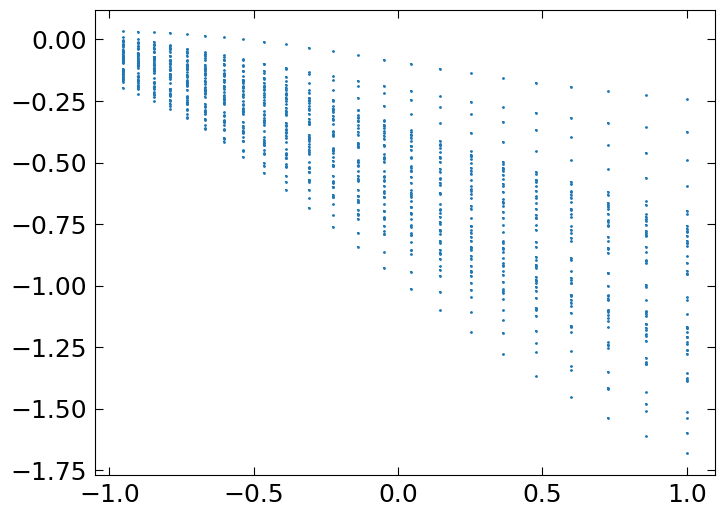

In [70]:
pc_idx=0
i=-1
plt.errorbar(emu.design_scaled[:,i], emu.pcs_spec[:,0,pc_idx], np.sqrt(emu.pc_vars_spec[:,0,pc_idx]), marker='o', ls='', markersize=1)


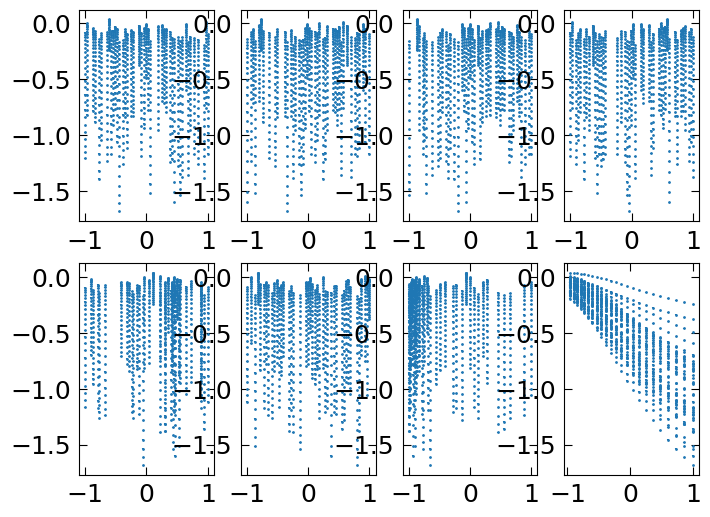

In [89]:
f, ax = plt.subplots(2,4)
pc_idx=0
for i in range(8):
#    ax[i//4,i%4].plot(emu_kecleft.design[:,i], emu_kecleft.pcs_spec_normed[:,0,pc_idx], marker='o', ls='', markersize=1)
#    ax[i//4,i%4].plot(emu_orig.design[:,i], emu_orig.pcs_spec_normed[:,0,pc_idx], marker='o', ls='', markersize=1)
    ax[i//4,i%4].errorbar(emu.design_scaled[:,i], emu.pcs_spec[:,0,pc_idx], np.sqrt(emu.pc_vars_spec[:,0,pc_idx]), marker='o', ls='', markersize=1)


In [426]:
simoverlpt = emu.simoverlpt

In [429]:
Xs = np.zeros((emu.nspec, emu.nk * emu.nz, emu.nk * emu.nz))


In [434]:
simoverlpt = np.swapaxes(emu.simoverlpt, 1, 2).reshape(42, emu.nspec, -1)

In [442]:
evec_spec = np.zeros((emu.nspec, emu.nk * emu.nz, emu.nk*emu.nz))

# variance per PC
vars_spec = np.zeros((emu.nspec, emu.nk * emu.nz))

for i in range(emu.nspec):
    Xs[i, :, :] = np.cov(simoverlpt[:, i, ...].T)

for si in range(emu.nspec):
    var, pcs = np.linalg.eig(Xs[si, ...])

    evec_spec[si, :, :] = pcs
    vars_spec[si, :] = var    

 /var/folders/q3/6gs6_y8s2g18tsm2881649l80000gn/T/ipykernel_15761/131366336.py:12: ComplexWarning:Casting complex values to real discards the imaginary part
 /var/folders/q3/6gs6_y8s2g18tsm2881649l80000gn/T/ipykernel_15761/131366336.py:13: ComplexWarning:Casting complex values to real discards the imaginary part


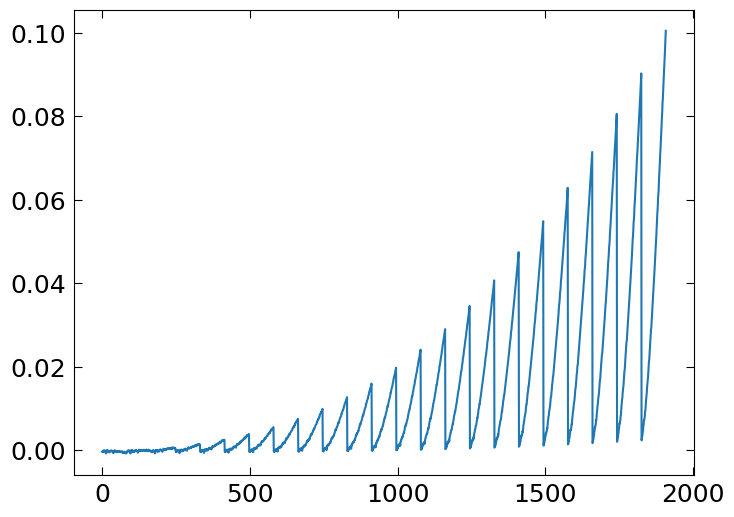

In [447]:
plt.plot(evec_spec[0,:,0])

(0.0, 10.0)

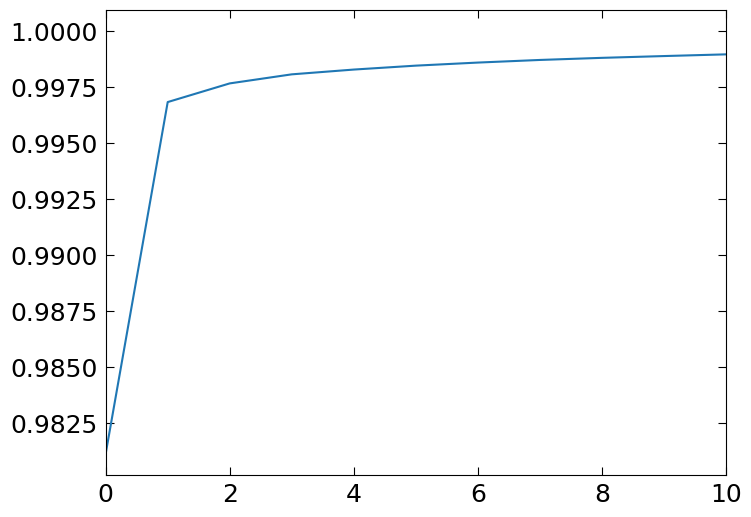

In [444]:
plt.plot(np.cumsum(vars_spec[0,:])/np.sum(vars_spec[0,:]))
plt.xlim([0,10])

In [8]:
%pdb

Automatic pdb calling has been turned ON


In [63]:
st = time.time()
train_nbody_file = '../anzu/data/zcv_za_aemulus_nu_tier2_cut_spectra.npy'
train_lpt_file =   '../anzu/data/lpt_aemulus_nu_tier2_cut_spectra.npy'
train_cosmo_file = '../anzu/data/aemulus_nu_tier2_cut_cosmos.txt'
k_file = '../anzu/data/kbins_aemulus_nu.npy'
z_file = '../anzu/data/'
npc=5
#
emu = LPTEmulator(aemulus_alpha_settings=False, nbody_training_data_file=train_nbody_file,
                  lpt_training_data_file=train_lpt_file, training_cosmo_file=train_cosmo_file,
                  zs=zs, kbin_file=k_file, extrap=True, use_sigma_8=True, 
                  smooth_spectra=True, tanh=False, kmax=0.6,
                  hyperparams={'npc':npc, 'ncv':None, 'degree_cv':0, 
                               'npoly':np.array([1, 2, 1, 1, 3, 2, 1])},
                  kmin_pl=0.7, kmax_pl=0.8, zpc=True, zmax=3.0,
)

 /Users/jderose/projects/anzu/anzu/emu_funcs.py:385: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/jderose/projects/anzu/anzu/emu_funcs.py:386: ComplexWarning:Casting complex values to real discards the imaginary part


In [64]:
nbody_file = '../anzu/data/zcv_za_aemulus_nu_tier2_spectra.npy'
lpt_file =   '../anzu/data/kelpt_aemulus_nu_tier2_spectra.npy'
cosmo_file = '../anzu/data/aemulus_nu_tier2_cosmos.txt'
nsim = 44
design_test, design_test_scaled = emu._setup_design(cosmo_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load(lpt_file)
spectra_aem_test = np.load(nbody_file)
spectra_aem_test_mean = spectra_aem_test

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(np.copy(spectra_lpt_test))
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx
test_cosmos = np.genfromtxt(cosmo_file, names=True)
#idx = (0.7 < test_cosmos['sigma8']) & (test_cosmos['sigma8'] < 0.9)
#nsim = np.sum(idx)
spectra_aem_reshape = spectra_aem_test_mean[:,zidx:,...].reshape(nsim * emu.nz, emu.nspec, -1)
spectra_lpt_test_reshape = spectra_lpt_test[:,zidx:,...].reshape(nsim * emu.nz, emu.nspec, -1)
spectra_aem_test_mean = spectra_aem_test_mean[:,zidx:,...]



In [65]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, z=zs, spec_lpt=spectra_lpt_test)#[...,:emu.kmax_idx])
#pce_spec = pce_spec.reshape(nsim, emu.nz, emu.nspec, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec, _ = emu.predict(emu.k[:emu.kmax_idx], design_test, z=zs,
                          evec_spec=emu.evec_spec[...,:npc], simoverlpt=simoverlpt_test,
                          spec_lpt=spectra_lpt_test)#[...,:emu.kmax_idx])
#pca_spec = pca_spec.reshape(nsim, emu.nz, emu.nspec, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

#resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
#resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
#
#counter = 0
#dk = k[1:] - k[:-1]
#            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#
#for i in range(4):
#    for j in range(4):
#        if j>i:
#            continue
#
#        for ki in range(nz):
#            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
#
#        counter+=1

In [66]:
resids_emu = (pce_spec[:,:,:,:] - spectra_aem_test_mean[:,:,:,:kmax_idx])/spectra_aem_test_mean[:,:,:,:kmax_idx]
resids_pca = (pca_spec[:,:,:,:] - spectra_aem_test_mean[:,:,:,:kmax_idx])/spectra_aem_test_mean[:,:,:,:kmax_idx]

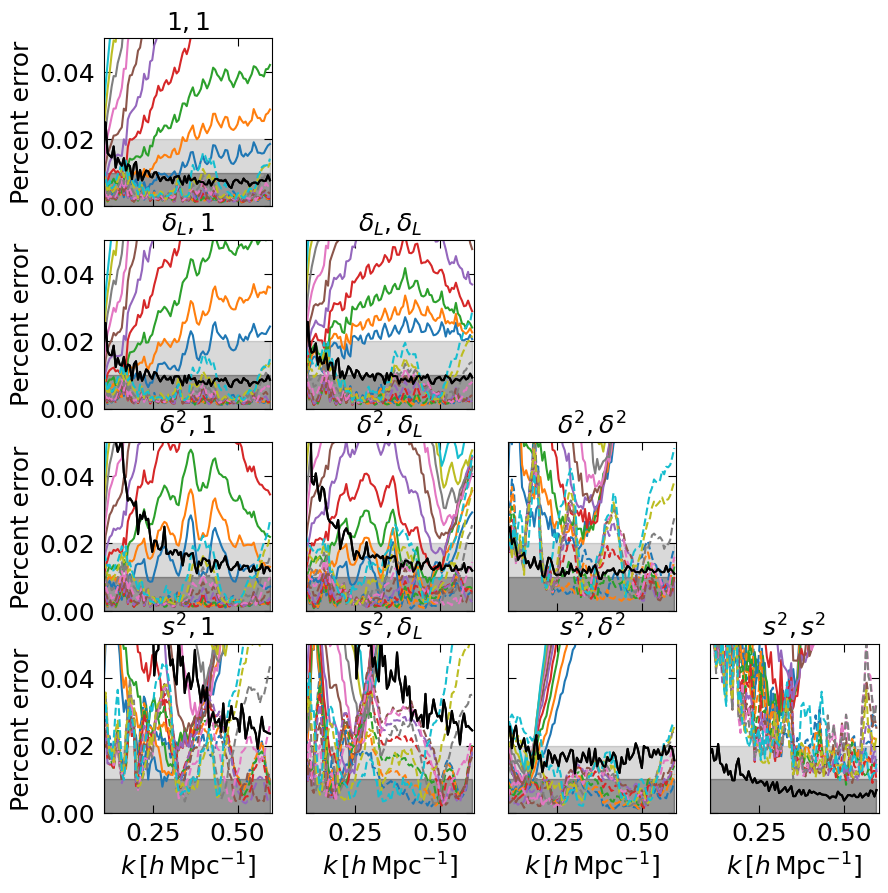

In [67]:
varpk = np.nanmean(np.nanstd(spectra_aem_alpha_test, axis=1), axis=(0))
meanpk = np.nanmean(np.nanmean(spectra_aem_alpha_test, axis=1), axis=(0))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
zstep = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(np.abs(resids_emu[:,::zstep,counter,kmin_idx:kmax_idx].T), 66, axis=-1))

        
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[-1, counter, kmin_idx:kmax_idx].T/np.abs(meanpk[-1,counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')
            
#plt.gca().set_prop_cycle(None)
counter = 0
for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        ax[i,j].set_prop_cycle(None)
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.percentile(np.abs(resids_pca[:,::zstep,counter,kmin_idx:kmax_idx].T), 66, axis=-1), ls='--')
        
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[-1, counter, kmin_idx:kmax_idx].T/np.abs(meanpk[-1,counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
                    

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
#ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)
